In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None )
import numpy as np

from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, precision_score, recall_score, f1_score, classification_report, make_scorer

from datetime import datetime

rd = np.random.seed(1973)

import catboost as ctb
import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, cross_val_score
import eli5
from eli5.sklearn import PermutationImportance

import scikitplot as skplt

import matplotlib.pyplot as plt

In [4]:
df_train = pd.read_hdf("../input/train_churn_pred.h5")
df_test = pd.read_hdf("../input/test_churn_pred.h5")
df_train.shape, df_test.shape

((34999, 171), (35000, 170))

In [5]:
#df_train.info(verbose=True, memory_usage='deep')

In [6]:
feats_object = df_train.select_dtypes('object').columns.to_list()
feats_object

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [8]:
train = df_train.copy()
test = df_test.copy()

In [9]:
for feat in feats_object:
    train[feat] = pd.to_datetime(train[feat], format="%m/%d/%Y")
    test[feat] = pd.to_datetime(test[feat], format="%m/%d/%Y")
    
train['date_of_last_rech_6_year'] = train['date_of_last_rech_6'].apply(lambda x: x.year)
train['date_of_last_rech_7_year'] = train['date_of_last_rech_7'].apply(lambda x: x.year)
train['date_of_last_rech_8_year'] = train['date_of_last_rech_8'].apply(lambda x: x.year)

train['date_of_last_rech_6_month'] = train['date_of_last_rech_6'].apply(lambda x: x.month)
train['date_of_last_rech_7_month'] = train['date_of_last_rech_7'].apply(lambda x: x.month)
train['date_of_last_rech_8_month'] = train['date_of_last_rech_8'].apply(lambda x: x.month)

train['date_of_last_rech_6_day'] = train['date_of_last_rech_6'].apply(lambda x: x.day)
train['date_of_last_rech_7_day'] = train['date_of_last_rech_7'].apply(lambda x: x.day)
train['date_of_last_rech_8_day'] = train['date_of_last_rech_8'].apply(lambda x: x.day)

test['date_of_last_rech_6_year'] = test['date_of_last_rech_6'].apply(lambda x: x.year)
test['date_of_last_rech_7_year'] = test['date_of_last_rech_7'].apply(lambda x: x.year)
test['date_of_last_rech_8_year'] = test['date_of_last_rech_8'].apply(lambda x: x.year)

test['date_of_last_rech_6_month'] = test['date_of_last_rech_6'].apply(lambda x: x.month)
test['date_of_last_rech_7_month'] = test['date_of_last_rech_7'].apply(lambda x: x.month)
test['date_of_last_rech_8_month'] = test['date_of_last_rech_8'].apply(lambda x: x.month)

test['date_of_last_rech_6_day'] = test['date_of_last_rech_6'].apply(lambda x: x.day)
test['date_of_last_rech_7_day'] = test['date_of_last_rech_7'].apply(lambda x: x.day)
test['date_of_last_rech_8_day'] = test['date_of_last_rech_8'].apply(lambda x: x.day)

In [10]:
# train.hist(figsize=(50,40), bins=50);

In [11]:
feats_to_ignore = [x for x in train.columns.to_list() if train[x].nunique() == 1  ]
feats_to_ignore = (feats_to_ignore + ['id'] + feats_object)

feats = [x for x in train.columns.to_list() if x not in feats_to_ignore]
feats_X = feats.copy()
feats_X.remove('churn_probability')
feats.append('churn_probability')

### fillna() for train

In [12]:
# list of all feats_X with NaN
train[feats_X].isna().sum().to_dict()

{'arpu_6': 0,
 'arpu_7': 0,
 'arpu_8': 0,
 'onnet_mou_6': 1385,
 'onnet_mou_7': 1341,
 'onnet_mou_8': 1858,
 'offnet_mou_6': 1385,
 'offnet_mou_7': 1341,
 'offnet_mou_8': 1858,
 'roam_ic_mou_6': 1385,
 'roam_ic_mou_7': 1341,
 'roam_ic_mou_8': 1858,
 'roam_og_mou_6': 1385,
 'roam_og_mou_7': 1341,
 'roam_og_mou_8': 1858,
 'loc_og_t2t_mou_6': 1385,
 'loc_og_t2t_mou_7': 1341,
 'loc_og_t2t_mou_8': 1858,
 'loc_og_t2m_mou_6': 1385,
 'loc_og_t2m_mou_7': 1341,
 'loc_og_t2m_mou_8': 1858,
 'loc_og_t2f_mou_6': 1385,
 'loc_og_t2f_mou_7': 1341,
 'loc_og_t2f_mou_8': 1858,
 'loc_og_t2c_mou_6': 1385,
 'loc_og_t2c_mou_7': 1341,
 'loc_og_t2c_mou_8': 1858,
 'loc_og_mou_6': 1385,
 'loc_og_mou_7': 1341,
 'loc_og_mou_8': 1858,
 'std_og_t2t_mou_6': 1385,
 'std_og_t2t_mou_7': 1341,
 'std_og_t2t_mou_8': 1858,
 'std_og_t2m_mou_6': 1385,
 'std_og_t2m_mou_7': 1341,
 'std_og_t2m_mou_8': 1858,
 'std_og_t2f_mou_6': 1385,
 'std_og_t2f_mou_7': 1341,
 'std_og_t2f_mou_8': 1858,
 'std_og_mou_6': 1385,
 'std_og_mou_7': 134

In [13]:
# list of feats with NaNs

feats_nan_train = [ x[0] for x in train[feats_X].isna().sum().to_dict().items() if x[1] > 0 ]
feats_nan_train

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

In [14]:
# check mins in feats
train[feats_nan_train].min().to_dict() 

{'onnet_mou_6': 0.0,
 'onnet_mou_7': 0.0,
 'onnet_mou_8': 0.0,
 'offnet_mou_6': 0.0,
 'offnet_mou_7': 0.0,
 'offnet_mou_8': 0.0,
 'roam_ic_mou_6': 0.0,
 'roam_ic_mou_7': 0.0,
 'roam_ic_mou_8': 0.0,
 'roam_og_mou_6': 0.0,
 'roam_og_mou_7': 0.0,
 'roam_og_mou_8': 0.0,
 'loc_og_t2t_mou_6': 0.0,
 'loc_og_t2t_mou_7': 0.0,
 'loc_og_t2t_mou_8': 0.0,
 'loc_og_t2m_mou_6': 0.0,
 'loc_og_t2m_mou_7': 0.0,
 'loc_og_t2m_mou_8': 0.0,
 'loc_og_t2f_mou_6': 0.0,
 'loc_og_t2f_mou_7': 0.0,
 'loc_og_t2f_mou_8': 0.0,
 'loc_og_t2c_mou_6': 0.0,
 'loc_og_t2c_mou_7': 0.0,
 'loc_og_t2c_mou_8': 0.0,
 'loc_og_mou_6': 0.0,
 'loc_og_mou_7': 0.0,
 'loc_og_mou_8': 0.0,
 'std_og_t2t_mou_6': 0.0,
 'std_og_t2t_mou_7': 0.0,
 'std_og_t2t_mou_8': 0.0,
 'std_og_t2m_mou_6': 0.0,
 'std_og_t2m_mou_7': 0.0,
 'std_og_t2m_mou_8': 0.0,
 'std_og_t2f_mou_6': 0.0,
 'std_og_t2f_mou_7': 0.0,
 'std_og_t2f_mou_8': 0.0,
 'std_og_mou_6': 0.0,
 'std_og_mou_7': 0.0,
 'std_og_mou_8': 0.0,
 'isd_og_mou_6': 0.0,
 'isd_og_mou_7': 0.0,
 'isd_og_mo

In [15]:
# only feats with 'arpu' has NaN
feats_arpu_train = [x for x in train[feats_nan_train].columns.to_list() if 'arpu' in x]
feats_arpu_train

['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

In [16]:
len(train[ train['arpu_2g_6'] == -1 ]['arpu_2g_6'])

1

In [17]:
for feat in feats_arpu_train:
    if len(train[ train[feat] == -1 ][feat]) >= 1:
        print(feat)

arpu_2g_6


In [18]:
for feat in feats_nan_train:
    if len(train[ train[feat] == -2 ][feat]) >= 1:
        print(feat)

In [19]:
train.fillna(-2, inplace=True)

### fillna() for test

In [20]:
# list of all feats_X with NaN
test[feats_X].isna().sum().to_dict()

{'arpu_6': 0,
 'arpu_7': 0,
 'arpu_8': 0,
 'onnet_mou_6': 1383,
 'onnet_mou_7': 1346,
 'onnet_mou_8': 1845,
 'offnet_mou_6': 1383,
 'offnet_mou_7': 1346,
 'offnet_mou_8': 1845,
 'roam_ic_mou_6': 1383,
 'roam_ic_mou_7': 1346,
 'roam_ic_mou_8': 1845,
 'roam_og_mou_6': 1383,
 'roam_og_mou_7': 1346,
 'roam_og_mou_8': 1845,
 'loc_og_t2t_mou_6': 1383,
 'loc_og_t2t_mou_7': 1346,
 'loc_og_t2t_mou_8': 1845,
 'loc_og_t2m_mou_6': 1383,
 'loc_og_t2m_mou_7': 1346,
 'loc_og_t2m_mou_8': 1845,
 'loc_og_t2f_mou_6': 1383,
 'loc_og_t2f_mou_7': 1346,
 'loc_og_t2f_mou_8': 1845,
 'loc_og_t2c_mou_6': 1383,
 'loc_og_t2c_mou_7': 1346,
 'loc_og_t2c_mou_8': 1845,
 'loc_og_mou_6': 1383,
 'loc_og_mou_7': 1346,
 'loc_og_mou_8': 1845,
 'std_og_t2t_mou_6': 1383,
 'std_og_t2t_mou_7': 1346,
 'std_og_t2t_mou_8': 1845,
 'std_og_t2m_mou_6': 1383,
 'std_og_t2m_mou_7': 1346,
 'std_og_t2m_mou_8': 1845,
 'std_og_t2f_mou_6': 1383,
 'std_og_t2f_mou_7': 1346,
 'std_og_t2f_mou_8': 1845,
 'std_og_mou_6': 1383,
 'std_og_mou_7': 134

In [21]:
# list of feats with NaNs

feats_nan_test = [ x[0] for x in test[feats_X].isna().sum().to_dict().items() if x[1] > 0 ]
feats_nan_test

['onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou

In [22]:
# check mins in feats
test[feats_nan_test].min().to_dict() 

{'onnet_mou_6': 0.0,
 'onnet_mou_7': 0.0,
 'onnet_mou_8': 0.0,
 'offnet_mou_6': 0.0,
 'offnet_mou_7': 0.0,
 'offnet_mou_8': 0.0,
 'roam_ic_mou_6': 0.0,
 'roam_ic_mou_7': 0.0,
 'roam_ic_mou_8': 0.0,
 'roam_og_mou_6': 0.0,
 'roam_og_mou_7': 0.0,
 'roam_og_mou_8': 0.0,
 'loc_og_t2t_mou_6': 0.0,
 'loc_og_t2t_mou_7': 0.0,
 'loc_og_t2t_mou_8': 0.0,
 'loc_og_t2m_mou_6': 0.0,
 'loc_og_t2m_mou_7': 0.0,
 'loc_og_t2m_mou_8': 0.0,
 'loc_og_t2f_mou_6': 0.0,
 'loc_og_t2f_mou_7': 0.0,
 'loc_og_t2f_mou_8': 0.0,
 'loc_og_t2c_mou_6': 0.0,
 'loc_og_t2c_mou_7': 0.0,
 'loc_og_t2c_mou_8': 0.0,
 'loc_og_mou_6': 0.0,
 'loc_og_mou_7': 0.0,
 'loc_og_mou_8': 0.0,
 'std_og_t2t_mou_6': 0.0,
 'std_og_t2t_mou_7': 0.0,
 'std_og_t2t_mou_8': 0.0,
 'std_og_t2m_mou_6': 0.0,
 'std_og_t2m_mou_7': 0.0,
 'std_og_t2m_mou_8': 0.0,
 'std_og_t2f_mou_6': 0.0,
 'std_og_t2f_mou_7': 0.0,
 'std_og_t2f_mou_8': 0.0,
 'std_og_mou_6': 0.0,
 'std_og_mou_7': 0.0,
 'std_og_mou_8': 0.0,
 'isd_og_mou_6': 0.0,
 'isd_og_mou_7': 0.0,
 'isd_og_mo

In [23]:
# only feats with 'arpu' has NaN
feats_arpu_test = [x for x in test[feats_nan_test].columns.to_list() if 'arpu' in x]
feats_arpu_test

['arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8']

In [24]:
for feat in feats_arpu_test:
    if len(test[ test[feat] == -1 ][feat]) >= 1:
        print(feat)

In [25]:
for feat in feats_nan_test:
    if len(test[ test[feat] == -1 ][feat]) >= 1:
        print(feat)

In [26]:
test.fillna(-1, inplace=True)

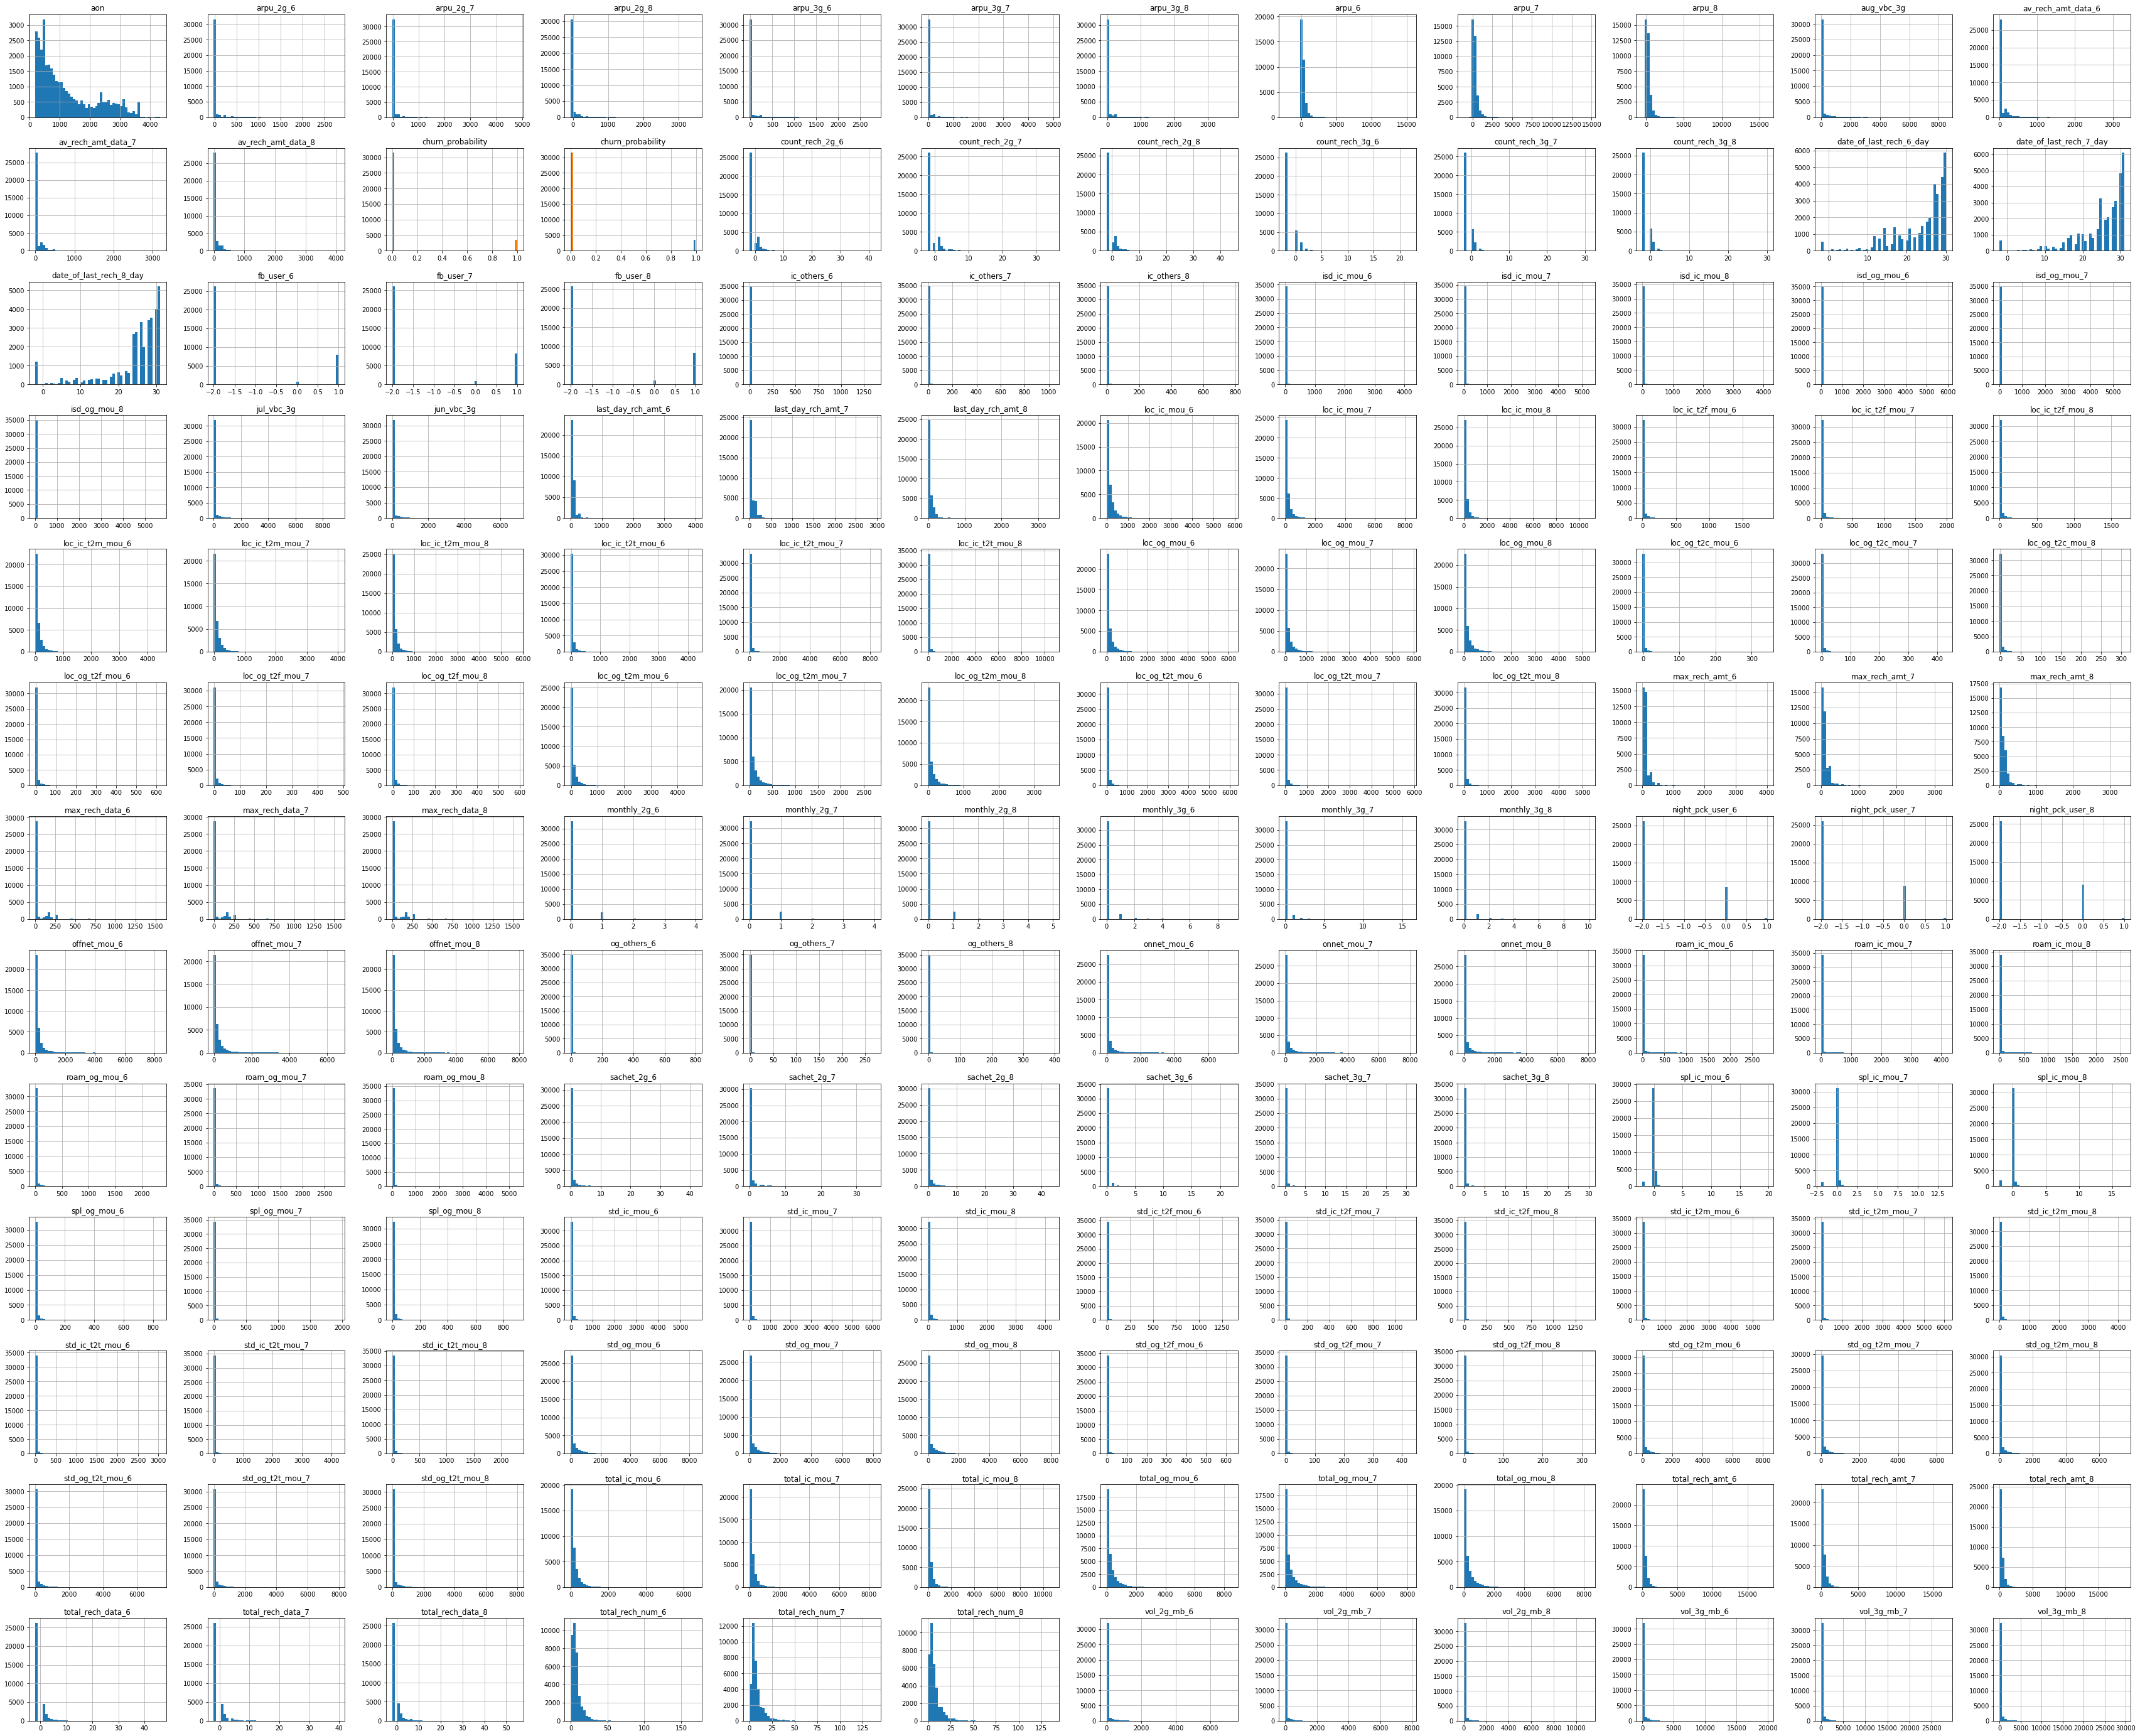

In [27]:
train[feats].hist(figsize=(60,50), bins=50);

In [28]:
[ x for x in train[feats_X].columns.to_list() if train[x].min() < 0 ]

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'lo

### normalization

In [29]:
train[feats_X].head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day
3,94.620003,138.817993,129.229004,57.540001,93.080002,79.730003,48.029999,110.00000,90.959999,0.0,0.0,0.0,0.0,0.0,0.00,8.540000,2.360000,39.029999,26.709999,71.779999,77.129997,0.00,0.26,2.94,0.00,0.00,0.00,35.259998,74.410004,119.125000,48.990002,90.709999,40.689999,21.309999,37.930000,10.880000,0.000000,0.000000,0.000000,70.309998,128.639999,51.580002,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,105.580002,203.059998,170.690002,6.210000,3.330000,15.780000,7.240000,18.010000,41.990002,0.000000,0.000000,0.000000,13.460000,21.340000,57.779999,1.11,23.530001,1.48,0.000000,2.560000,13.030000,0.00,0.000000,0.00,1.110000,26.090000,14.510000,14.960000,76.580002,72.290001,0.0,0.0,0.0,0.00,29.129999,0.00,0.38,0.0,0.0,3,2,5,120,120,310,120,120,130,120,0,130,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.000000,0.000000,0.00000,0.0,0.000000,-2.000000,-2.0,-2.000000,-2.000000,-2.000000,-2.000000,-2.0,-2.0,-2.0,0,0,0,0,0,0,0,0,0,0,0,0,-2.0,-2.0,-2.0,389,0.0,0.0,0.0,20.0,16.0,26.0
6,139.126007,183.020996,225.307999,57.959999,45.860001,62.860001,170.830002,213.25000,167.690002,0.0,0.0,0.0,0.0,0.0,0.00,57.959999,45.860001,62.860001,124.480003,116.790001,146.059998,7.28,2.85,3.38,0.00,0.00,0.00,189.729996,165.509995,212.250000,0.000000,0.000000,0.000000,0.000000,0.000000,1.350000,39.060001,93.589996,16.059999,39.060001,93.589996,17.410000,0.00,0.0,0.28,0.00,0.00,0.55,0.00,0.0,0.0,228.789993,259.109985,230.559998,47.240002,68.089996,61.090000,71.309998,122.879997,171.339996,21.639999,27.031250,53.610001,140.210007,218.009995,286.059998,0.00,0.000000,0.00,0.000000,0.000000,1.530000,1.18,4.680000,3.54,1.180000,4.680000,5.080000,141.479996,222.690002,291.209991,0.0,0.0,0.0,0.08,0.000000,0.06,0.00,0.0,0.0,2,2,3,

In [30]:
from sklearn.preprocessing import RobustScaler

# create a scaler object
scaler = RobustScaler()

# fit and transform the data
train_robust = pd.DataFrame(scaler.fit_transform(train[feats_X]), columns=feats_X)

train_robust

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day
0,-0.369436,-0.190368,-0.221447,0.243457,0.604275,0.499806,-0.215040,0.128653,0.043718,0.00,0.000000,0.00,0.000000,0.00,0.00,-0.052869,-0.215086,0.789939,-0.111201,0.361333,0.430086,0.000000,0.136842,1.651685,0.00,0.00,0.00,-0.167452,0.107154,0.423982,1.776287,3.191766,1.609891,0.377682,0.709645,0.197885,0.000000,0.000000,0.000000,0.457320,0.860504,0.344605,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.0,-0.119693,0.180323,0.098466,-0.189056,-0.266859,0.038868,-0.389255,-0.309166,-0.088329,-0.085079,-0.092072,-0.090909,-0.406541,-0.374594,-0.150098,0.307479,6.342318,0.431487,-0.110950,0.066441,0.838384,0.00,0.000000,0.00,-0.154983,0.798714,0.391425,-0.466153,-0.186214,-0.195285,0.00,0.00,0.0,0.000000,29.129999,0.00,0.38,0.0,0.0,-0.500000,-0.571429,0.000000,-0.330275,-0.304878,0.244957,0.111111,0.102041,0.280702,0.818182,-0.272727,0.769231,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.354815,0.0,0.00,0.0,-0.777778,-1.375,-0.166667
1,-0.208647,-0.031243,0.115434,0.247314,0.154710,0.335828,0.417461,0.668082,0.447868,0.00,0.000000,0.00,0.000000,0.00,0.00,1.260096,0.958845,1.437933,0.879878,0.828678,1.143241,3.956522,1.500000,1.898876,0.00,0.00,0.00,0.872610,0.732905,1.056981,0.000000,0.000000,0.000000,-0.057838,-0.055690,-0.012120,39.060001,93.589996,16.059999,0.223229,0.608283,0.079279,0.00,0.0,0.28,0.000000,0.000000,0.161290,0.00,0.0,0.0,0.254322,0.345797,0.277487,0.774542,1.292871,1.125960,0.176910,0.634164,1.051922,2.747382,3.413501,7.293388,0.311935,0.776701,1.166244,0.000000,0.000000,0.000000,-0.110950

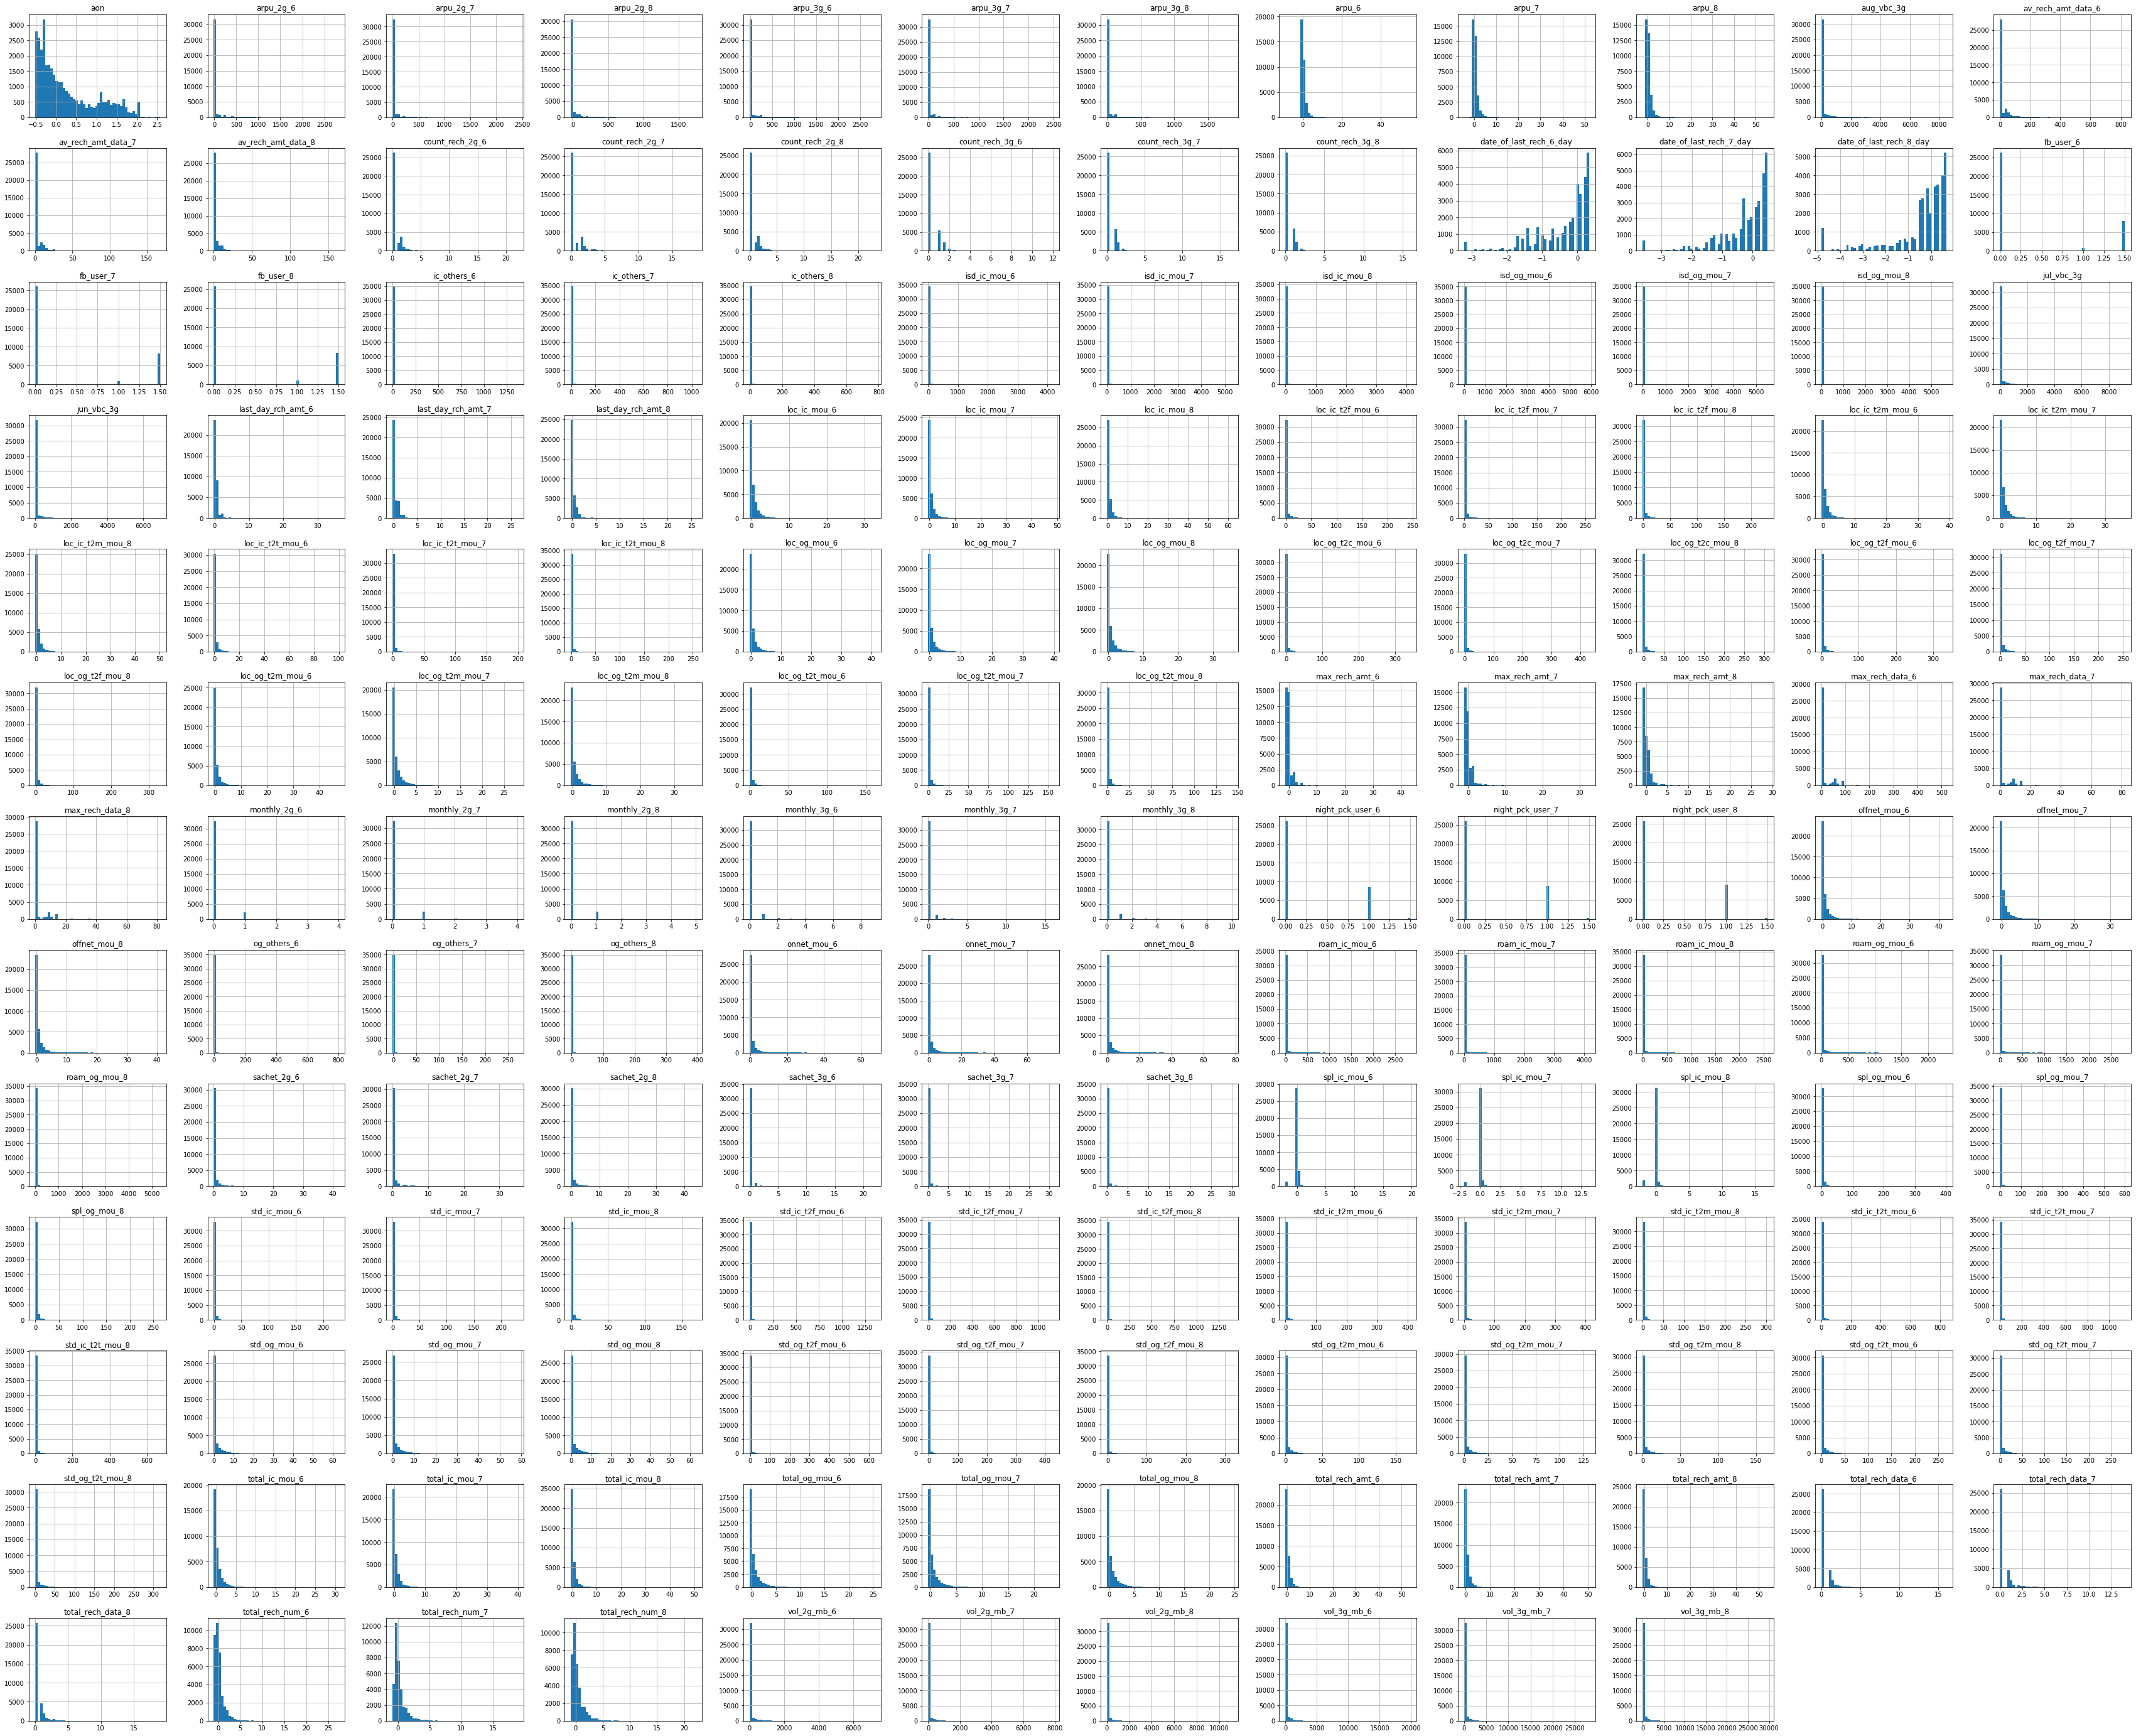

In [31]:
train_robust.hist(figsize=(60,50), bins=50);

### transformation

In [32]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method = 'yeo-johnson')

'''
parameters:
method = 'box-cox' or 'yeo-johnson'
'''

train_transf = pd.DataFrame(scaler.fit_transform(train_robust), columns=feats_X)
train_transf

# df_transf = train[feats_X].copy()
# df_transf = scaler.fit_transform(df_transf.values)
# df_transf

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day
0,-0.718646,-0.382489,-0.417797,0.282427,0.711659,0.608836,-0.575740,0.158421,0.011617,-0.157384,-0.097993,-0.050984,-0.177249,-0.113461,-0.063009,-0.320927,-0.843914,0.887571,-0.351903,0.502184,0.583525,-0.382698,-0.210486,0.734655,-0.107897,-0.129597,-0.099123,-0.480395,0.130269,0.578658,1.286479,1.554500,1.215777,0.326291,0.737819,-0.055686,-0.026197,-0.021768,0.023336,0.510746,0.939454,0.317301,0.09562,0.094259,0.138147,-0.410092,-0.514002,-0.481551,-0.083629,0.171425,0.204509,-0.349398,0.234036,0.101850,-0.640116,-0.879187,-0.027003,-1.103663,-0.811922,-0.228210,-0.740463,-0.752508,-0.704991,-1.105323,-0.979525,-0.363101,0.063330,1.688589,0.206664,-0.840636,-0.254371,0.874376,-0.110269,-0.112944,-0.071105,-0.791287,0.889217,0.471053,-1.209916,-0.399312,-0.425902,0.014293,0.064724,0.098025,-0.083513,1.963809,-0.057174,0.314251,-0.03953,0.003148,-0.852896,-1.324595,-0.046370,-0.616326,-0.577922,0.371560,0.552232,0.549904,0.583195,1.134383,-1.113428,1.236211,-0.577889,-0.589164,-0.600006,-0.577047,-0.584288,-0.594599,-0.577722,-0.588951,-0.599751,-0.577986,-0.589339,-0.600206,-0.576872,-0.585347,-0.594509,-0.517816,-0.525821,-0.526706,-0.410187,-0.426559,-0.434190,-0.332825,-0.427629,-0.364547,-0.375411,-0.451449,-0.341220,-0.578105,-0.589499,-0.600415,-0.278428,-0.286741,-0.282753,-0.386114,-0.396153,-0.406750,-0.245925,-0.245925,-0.256341,-0.210647,-0.211754,-0.212122,-0.578065,-0.589447,-0.600340,-1.037219,-0.444749,-0.436108,-0.41957,-0.918200,-1.389844,-0.240781
1,-0.433364,-0.105019,0.179160,0.288522,0.124542,0.411139,0.548638,0.782221,0.581493,-0.157384,-0.097993,-0.050984,-0.177249,-0.113461,-0.063009,1.158950,1.003766,1.237219,0.973141,0.936966,1.132161,1.312570,0.730152,0.817949,-0.107897,-0.129597,-0.099123,0

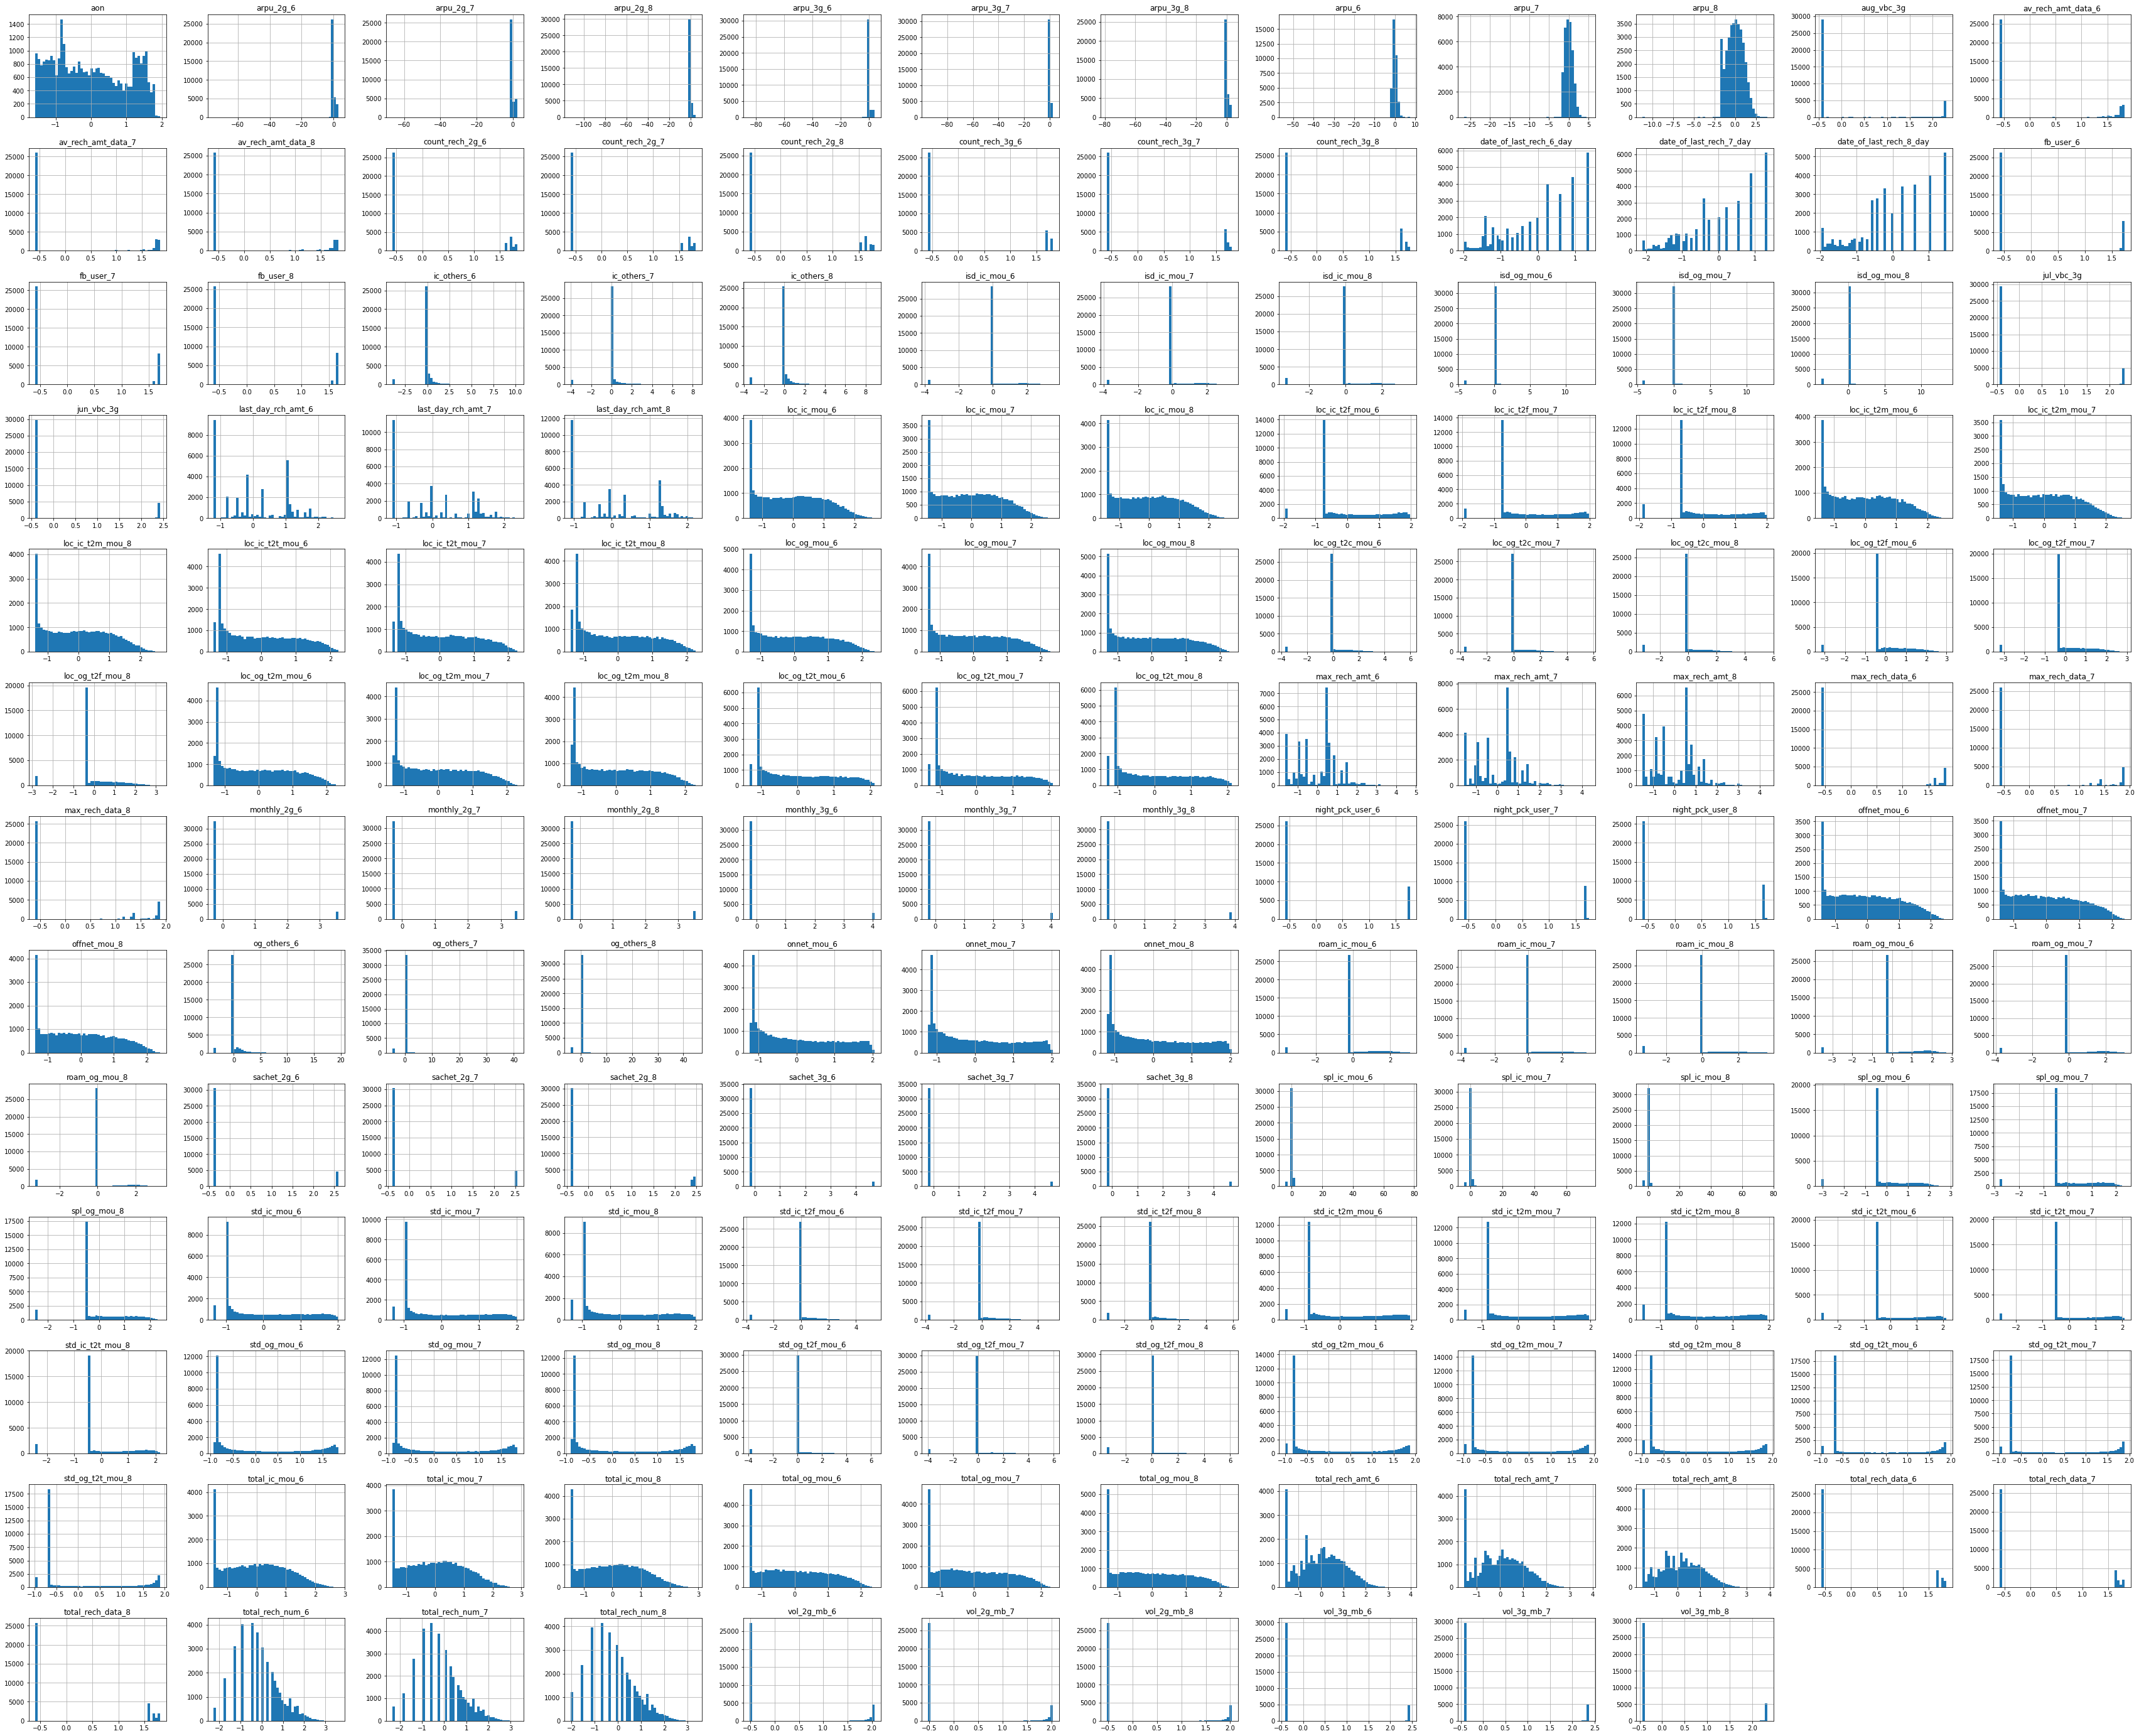

In [33]:
train_transf.hist(figsize=(60,50), bins=50);

### X_train, y_train, X_test

In [35]:
train_transf.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day
0,-0.718646,-0.382489,-0.417797,0.282427,0.711659,0.608836,-0.575740,0.158421,0.011617,-0.157384,-0.097993,-0.050984,-0.177249,-0.113461,-0.063009,-0.320927,-0.843914,0.887571,-0.351903,0.502184,0.583525,-0.382698,-0.210486,0.734655,-0.107897,-0.129597,-0.099123,-0.480395,0.130269,0.578658,1.286479,1.554500,1.215777,0.326291,0.737819,-0.055686,-0.026197,-0.021768,0.023336,0.510746,0.939454,0.317301,0.09562,0.094259,0.138147,-0.410092,-0.514002,-0.481551,-0.083629,0.171425,0.204509,-0.349398,0.234036,0.101850,-0.640116,-0.879187,-0.027003,-1.103663,-0.811922,-0.228210,-0.740463,-0.752508,-0.704991,-1.105323,-0.979525,-0.363101,0.063330,1.688589,0.206664,-0.840636,-0.254371,0.874376,-0.110269,-0.112944,-0.071105,-0.791287,0.889217,0.471053,-1.209916,-0.399312,-0.425902,0.014293,0.064724,0.098025,-0.083513,1.963809,-0.057174,0.314251,-0.03953,0.003148,-0.852896,-1.324595,-0.046370,-0.616326,-0.577922,0.371560,0.552232,0.549904,0.583195,1.134383,-1.113428,1.236211,-0.577889,-0.589164,-0.600006,-0.577047,-0.584288,-0.594599,-0.577722,-0.588951,-0.599751,-0.577986,-0.589339,-0.600206,-0.576872,-0.585347,-0.594509,-0.517816,-0.525821,-0.526706,-0.410187,-0.426559,-0.434190,-0.332825,-0.427629,-0.364547,-0.375411,-0.451449,-0.341220,-0.578105,-0.589499,-0.600415,-0.278428,-0.286741,-0.282753,-0.386114,-0.396153,-0.406750,-0.245925,-0.245925,-0.256341,-0.210647,-0.211754,-0.212122,-0.578065,-0.589447,-0.600340,-1.037219,-0.444749,-0.436108,-0.41957,-0.918200,-1.389844,-0.240781
1,-0.433364,-0.105019,0.179160,0.288522,0.124542,0.411139,0.548638,0.782221,0.581493,-0.157384,-0.097993,-0.050984,-0.177249,-0.113461,-0.063009,1.158950,1.003766,1.237219,0.973141,0.936966,1.132161,1.312570,0.730152,0.817949,-0.107897,-0.129597,-0.099123,0

In [36]:
test.head()

,id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,date_of_last_rech_6_year,date_of_last_rech_7_year,date_of_last_rech_8_year,date_of_last_rech_6_month,date_of_last_rech_7_month,date_of_last_rech_8_month,date_of_last_rech_6_day,date_of_last_rech_7_day,date_of_last_rech_8_day
0,0,0.0,0.0,0.0,30,31,31,11.200000,672.995972,578.088013,0.000000,17.280001,26.959999,11.430000,258.000000,332.410004,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,2.590000,10.390000,11.430000,248.210007,274.459991,0.00,0.43,0.0,0.00,9.11,0.58,11.430000,251.240005,284.750,0.00,14.68,16.559999,0.000000,0.23,57.360001,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,14.91,73.93,0.0,0.0,0.0,0.000000,10.190000,3.330000,0.00,0.0,0.0,11.430000,276.359985,362.130005,0.000000,0.000000,0.000000,1.430000,184.509995,164.179993,0.00,0.000000,0.00,1.430000,184.509995,164.179993,0.0,10.88,29.540001,0.000000,1.140000,0.000000,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,12.030000,29.540001,1.430000,196.539993,193.940002,0.0,0.0,0.21,0.0,0.0,0.0,0.00,0.0,0.0,1,10,12,0,361,724,0,110,154,2014-06-12 00:00:00,2014-07-25 00:00:00,2014-08-28 00:00:00,0,30,130,-1,2014-07-22 00:00:00,2014-08-01 00:00:00,-1.0,4.0,1.0,-1.0,252.0,154.0,-1.0,3.0,1.0,-1.0,1.0,0.0,-1.0,348.0,154.0,0.00,22.920000,48.07,0.0,1211.0,751.289978,-1.00,14.59,0.000000,-1.00,0.000000,0.000000,-1.0,0.0,0.0,0,0,1,0,3,0,0,1,0,0,0,0,-1.0,1.0,1.0,302,383.170013,1007.099976,0.0,2014.0,2014.0,2014.0,6.0,7.0,8.0,12.0,25.0,28.0
1,1,0.0,0.0,0.0,30,31,31,165.908997,251.362000,254.197998,70.959999,40.459999,41.040001,135.309

In [37]:
X_train = train_transf.values
y_train = train["churn_probability"].values

X_test  = test[feats_X].values 

### cal_metrics

In [38]:
def cal_metrics(y_test, y_pred):
    return {
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": fbeta_score(y_test, y_pred, beta=1.0),
        "f1.5": fbeta_score(y_test, y_pred, beta=1.5),
    }

### custom scorer

In [39]:
f1_5_scorer = make_scorer(fbeta_score, beta=1.5)

#model_xgbm = XGBClassifier(objective=f1_5_scorer)

### cv = StratifiedKFold

In [40]:
cv = StratifiedKFold(n_splits=3)

model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=f1_5_scorer)

np.mean(scores), np.std(scores)

(0.6416432626134188, 0.002662457003207215)

### model fit and predict

In [41]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
df_test["churn_probability"] = y_pred

df_test["churn_probability"].value_counts()

0    34744
1      256
Name: churn_probability, dtype: int64

In [ ]:
df_test[ ["id", "churn_probability"] ].to_csv("../output/xgb_dummy2.csv", index=False)

### experiments

In [43]:
X_train = train[feats_X].values
y_train = train["churn_probability"].values

X_test  = test[feats_X].values 

In [44]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3):    
     
    X_train = train[feats_X].values
    y_train = train["churn_probability"].values
    
    f1_5_scorer = make_scorer(fbeta_score, beta=1.5)

    scores = []
    cv=StratifiedKFold(n_splits=n_splits)                                 #shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring="f1", random_state=rd)

In [51]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10478
           1       0.73      0.62      0.67      1189

    accuracy                           0.94     11667
   macro avg       0.84      0.80      0.82     11667
weighted avg       0.93      0.94      0.94     11667

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10478
           1       0.74      0.60      0.66      1188

    accuracy                           0.94     11666
   macro avg       0.85      0.79      0.81     11666
weighted avg       0.93      0.94      0.93     11666

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     10477
           1       0.76      0.61      0.68      1189

    accuracy                           0.94     11666
   macro avg       0.86      0.80      0.82     11666
weighted avg       0.94      0.94      0.94     11666

Score:  0.670576305

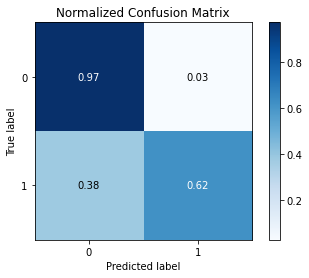

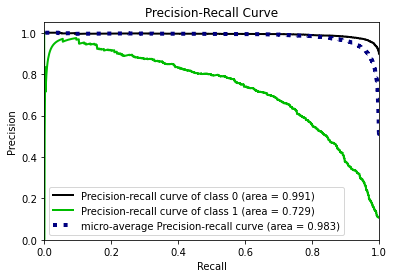

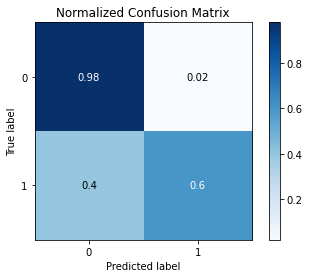

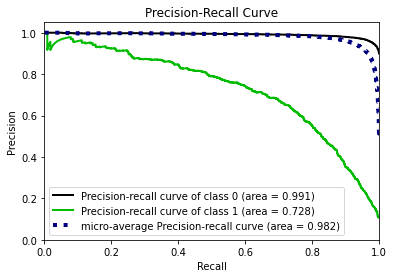

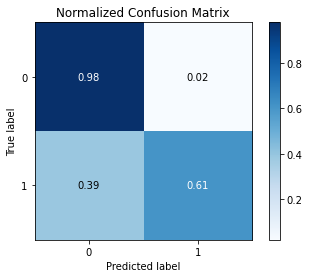

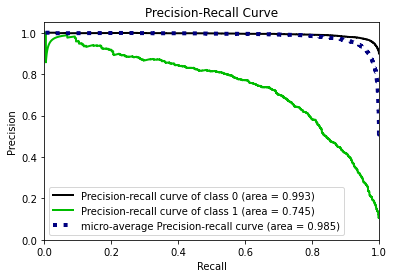

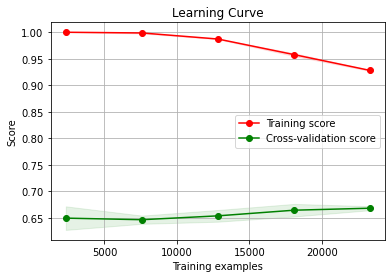

In [45]:
model = model
make_experiment(model)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10478
           1       0.61      0.76      0.67      1189

    accuracy                           0.93     11667
   macro avg       0.79      0.85      0.82     11667
weighted avg       0.93      0.93      0.93     11667

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10478
           1       0.63      0.74      0.68      1188

    accuracy                           0.93     11666
   macro avg       0.80      0.85      0.82     11666
weighted avg       0.94      0.93      0.93     11666

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10477
           1       0.64      0.76      0.69      1189

    accuracy                           0.93     11666
   macro avg       0.81      0.86      0.83     11666
weighted avg       0.94      0.93      0.93     11666

Score:  0.682964146

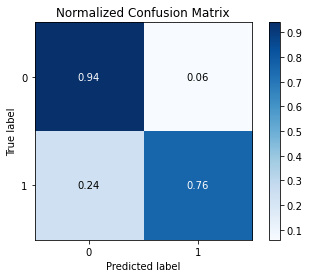

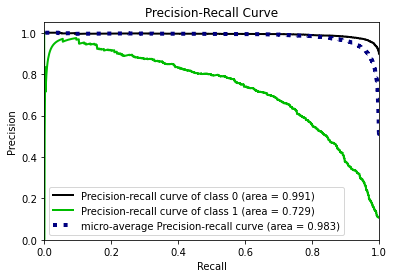

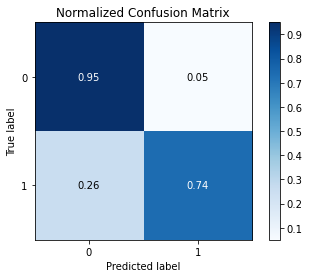

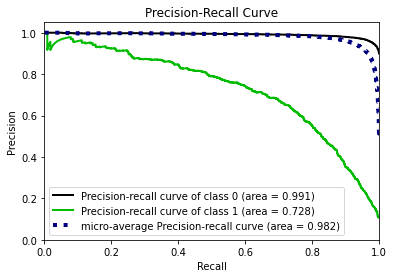

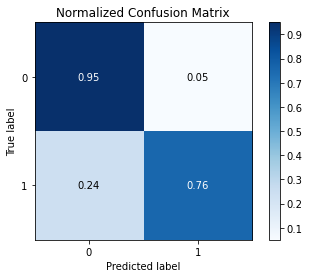

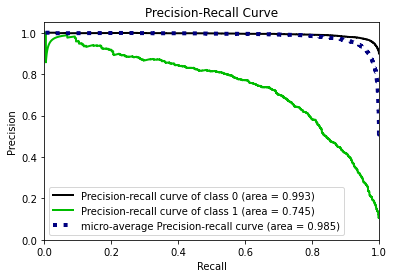

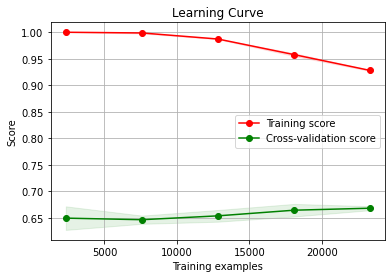

In [46]:
make_experiment(model, threshold=0.2 )

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     10478
           1       0.61      0.78      0.68      1189

    accuracy                           0.93     11667
   macro avg       0.79      0.86      0.82     11667
weighted avg       0.94      0.93      0.93     11667

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     10478
           1       0.62      0.76      0.68      1188

    accuracy                           0.93     11666
   macro avg       0.79      0.85      0.82     11666
weighted avg       0.94      0.93      0.93     11666

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     10477
           1       0.63      0.79      0.70      1189

    accuracy                           0.93     11666
   macro avg       0.80      0.87      0.83     11666
weighted avg       0.94      0.93      0.93     11666

Score:  0.688297198

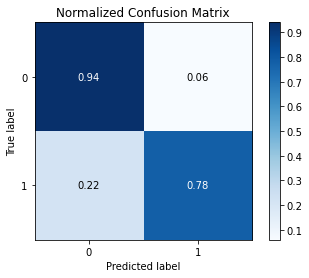

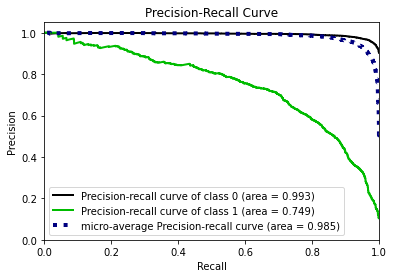

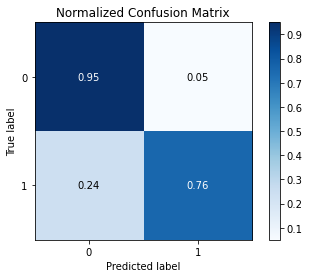

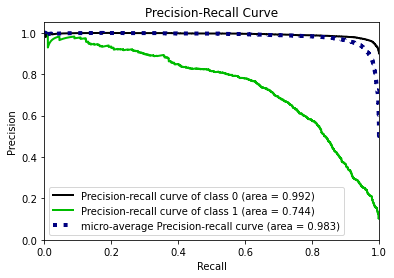

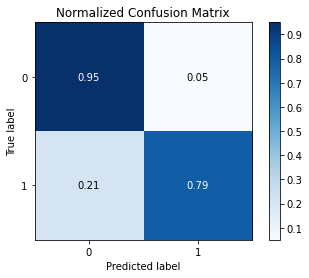

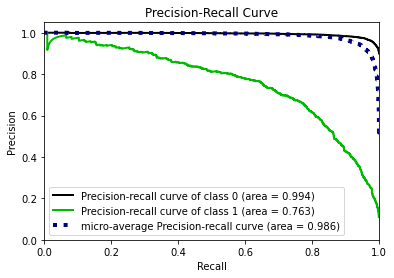

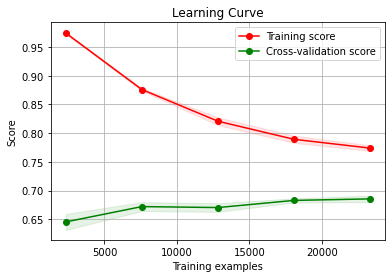

In [49]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, random_state=rd)
make_experiment(model, threshold=0.2)

In [ ]:
model = xgb.XGBClassifier(max_depth=6, n_estimators=500, learning_rate=0.01, random_state=rd)
make_experiment(model, threshold=0.2, n_splits=5)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      6287
           1       0.60      0.78      0.68       713

    accuracy                           0.92      7000
   macro avg       0.79      0.86      0.82      7000
weighted avg       0.94      0.92      0.93      7000

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      6287
           1       0.62      0.80      0.70       713

    accuracy                           0.93      7000
   macro avg       0.80      0.87      0.83      7000
weighted avg       0.94      0.93      0.93      7000

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      6287
           1       0.62      0.77      0.69       713

    accuracy                           0.93      7000
   macro avg       0.80      0.86      0.82      7000
weighted avg       0.94      0.93      0.93      7000

              preci

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.01, random_state=rd)
make_experiment(model, threshold=0.1, n_splits=5)

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.01, scale_pos_weight=9, random_state=rd)
make_experiment(model, threshold=0.2, n_splits=5)

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.01, scale_pos_weight=9, random_state=rd)
make_experiment(model, threshold=0.1, n_splits=5)

In [ ]:
def make_experiment(model, feats=None, threshold=0.5, n_splits=3):    
     
    X_train = train[feats_X].values
    y_train = train["churn_probability"].values
    
    f1_5_scorer = make_scorer(fbeta_score, beta=1.5)

    scores = []
    cv=StratifiedKFold(n_splits=n_splits)                                 #shuffle=True, random_state=0
    for train_idx, test_idx in cv.split(X_train, y_train):    

        model.fit(X_train[train_idx], y_train[train_idx])

        y_probas = model.predict_proba(X_train[test_idx])
        y_pred = (y_probas[:,1] > threshold).astype(np.int)
        
        #y_pred = model.predict(X_train[test_idx])

        print(classification_report(y_train[test_idx], y_pred))
        
        skplt.metrics.plot_confusion_matrix(y_train[test_idx], y_pred, normalize=True)
        skplt.metrics.plot_precision_recall(y_train[test_idx], y_probas)

        score = fbeta_score(y_train[test_idx], y_pred, beta=1.5)
#         score = f1_score(y_train[test_idx], y_pred)
        scores.append(score)
    
    
    print("Score: ", np.mean(scores), np.std(scores))
    
    skplt.estimators.plot_learning_curve(model, X_train, y_train, cv=cv, scoring=f1_5_scorer, random_state=rd)

In [ ]:
model = xgb.XGBClassifier(max_depth=5, n_estimators=100, learning_rate=0.3, random_state=rd)

make_experiment(model)

In [ ]:
make_experiment(model, threshold=0.2 )

In [ ]:
make_experiment(model, threshold=0.1 )